# World Values Survey Data

## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_sas('data/WVS_CrossNat_W7_v1_6.sas7bdat', format='sas7bdat')

In [3]:
data.describe()

,A_WAVE,A_STUDY,B_COUNTRY,C_COW_NUM,A_YEAR,D_INTERVIEW,J_INTDATE,FW_END,FW_START,K_TIME_START,...,WVS_Polmistrust_PartyVoter,WVS_LR_MedianVoter,WVS_LibCon_MedianVoter,v2psbars,v2psorgs,v2psprbrch,v2psprlnks,v2psplats,v2xnp_client,v2xps_party
count,70867.0,70867.0,70867.000000,70867.000000,70867.000000,7.086700e+04,6.798700e+04,70867.000000,70867.000000,59231.000000,...,29793.000000,18949.000000,18949.000000,18949.000000,18949.000000,18949.000000,18949.000000,18949.000000,18949.000000,18949.000000
mean,7.0,2.0,427.417134,514.574978,2018.356922,4.277022e+08,2.018323e+07,201839.059365,201823.025865,14.031349,...,66.543995,5.952974,7.401595,1.387780,1.454215,1.262951,0.602572,1.445392,0.436797,0.730929
std,0.0,0.0,248.622770,291.107448,0.955816,2.486329e+08,8.813118e+03,90.562074,89.629041,3.754853,...,9.055567,0.629833,1.451443,0.830643,0.741533,0.904170,1.117618,0.939847,0.231711,0.195485
min,7.0,2.0,20.000000,2.000000,2017.000000,2.007000e+07,2.017010e+07,201703.000000,201701.000000,0.000000,...,37.500000,4.740000,3.375000,-1.235000,-0.652000,-0.648000,-1.323000,-1.037000,0.034000,0.213000
25%,7.0,2.0,196.000000,160.000000,2018.000000,1.967009e+08,2.018020e+07,201805.000000,201801.000000,11.300000,...,59.720799,5.420000,6.512500,0.718000,1.158000,0.737000,-0.398000,1.052000,0.302000,0.560000
50%,7.0,2.0,400.000000,640.000000,2018.000000,4.000706e+08,2.018072e+07,201808.000000,201806.000000,14.060000,...,66.810345,5.750000,7.665800,1.496000,1.494000,1.317000,0.582000,1.531000,0.471000,0.750000
75%,7.0,2.0,642.000000,740.000000,2019.000000,6.420702e+08,2.019071e+07,201906.000000,201905.000000,16.590000,...,72.763761,6.430000,8.286600,2.043000,1.916000,2.186000,0.943000,2.193000,0.611000,0.909000
max,7.0,2.0,840.000000,993.000000,2020.000000,8.400736e+08,2.020081e+07,202008.000000,202007.000000,23.580000,...,100.000000,7.260000,9.402100,2.483000,3.031000,3.237000,2.707000,2.836000,0.794000,0.999000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70867 entries, 0 to 70866
Columns: 547 entries, version to v2xps_party
dtypes: float64(538), object(9)
memory usage: 295.7+ MB


In [5]:
data.iloc[0,:10]

version                  b'1-6-0 (2021-01-12)'
doi                b'doi.org/10.14281/18241.1'
A_WAVE                                     7.0
A_STUDY                                    2.0
B_COUNTRY                                 20.0
B_COUNTRY_ALPHA                         b'AND'
C_COW_NUM                                232.0
C_COW_ALPHA                             b'AND'
A_YEAR                                  2018.0
D_INTERVIEW                         20070001.0
Name: 0, dtype: object

<AxesSubplot:>

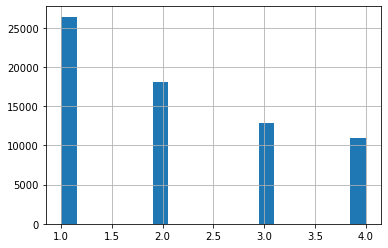

In [20]:
data['Q142'].hist(bins=20)

In [7]:
drop = ['version', 'doi', 'A_WAVE', 'A_STUDY', 'B_COUNTRY_ALPHA']
data.drop(drop,axis=1)

,B_COUNTRY,C_COW_NUM,C_COW_ALPHA,A_YEAR,D_INTERVIEW,J_INTDATE,FW_END,FW_START,K_TIME_START,K_TIME_END,...,WVS_Polmistrust_PartyVoter,WVS_LR_MedianVoter,WVS_LibCon_MedianVoter,v2psbars,v2psorgs,v2psprbrch,v2psprlnks,v2psplats,v2xnp_client,v2xps_party
0,20.0,232.0,b'AND',2018.0,20070001.0,20180704.0,201809.0,201807.0,18.20,19.48,...,62.434211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20.0,232.0,b'AND',2018.0,20070002.0,20180714.0,201809.0,201807.0,9.35,11.00,...,62.434211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20.0,232.0,b'AND',2018.0,20070003.0,20180704.0,201809.0,201807.0,10.15,10.45,...,62.434211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20.0,232.0,b'AND',2018.0,20070004.0,20180702.0,201809.0,201807.0,17.05,18.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20.0,232.0,b'AND',2018.0,20070005.0,20180708.0,201809.0,201807.0,10.20,11.48,...,66.964286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70862,716.0,552.0,b'ZIM',2020.0,716071211.0,20200322.0,202003.0,202002.0,10.51,12.08,...,66.710771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70863,716.0,552.0,b'ZIM',2020.0,716071212.0,20200322.0,202003.0,202002.0,12.25,13.45,...,NaN,4.74,9.0027,1.153,-0.154,-0.412,-0.338,1.169,0.763,0.56
70864,716.0,552.0,b'ZIM',2020.0,716071213.0,20200322.0,202003.0,202002.0,14.23,15.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70865,716.0,552.0,b'ZIM',2020.0,716071214.0,20200322.0,202003.0,202002.0,15.34,16.57,...,NaN,4.74,9.0027,1.153,-0.154,-0.412,-0.338,1.169,0.763,0.56


In [8]:
from src.pipeline import create_Xy, country_codes

In [9]:
X, y = create_Xy(data)

In [10]:
country_codes = country_codes()

## Classification modeling

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [12]:
X.isna().sum()

Q1       110
Q2       253
Q3       403
Q4       853
Q5       683
        ... 
Q194    4232
Q195    1776
Q196    2776
Q197    3494
Q198    3238
Length: 186, dtype: int64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.1,
                                                    random_state=0)

In [14]:
X_train.mean()

Q1      1.099788
Q2      1.740988
Q3      1.802763
Q4      2.605289
Q5      1.518341
          ...   
Q194    1.974320
Q195    4.044459
Q196    2.241200
Q197    2.836695
Q198    2.916827
Length: 186, dtype: float64

In [15]:
X_m = X_train.mean()
X_train = X_train.fillna(X_m)
X_test = X_test.fillna(X_m)
X = X.fillna(X_m)

In [16]:
X_train.shape

(63780, 186)

In [20]:
gb = GradientBoostingClassifier(learning_rate=0.1, 
                                  n_estimators=30,
                                  max_depth=3)
gb.fit(X_train, y_train)
y_hat = gb.predict(X_test)
print(f"accuracy = {gb.score(X_test, y_test)}")

accuracy = 0.7715535487512346


In [16]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=100,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

accuracy = 0.803442923663045


In [44]:
print(f"accuracy = {rf.score(X_test, y_test)}")

accuracy = 0.8876816706645971


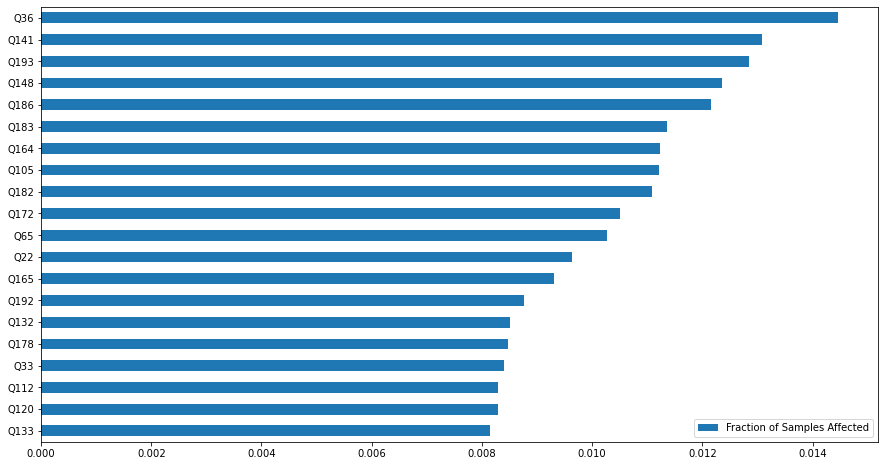

In [17]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores[-20:].plot(kind='barh', figsize=(15,8));

In [17]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

In [18]:
names = data.columns
 
rf = RandomForestClassifier()
scores = defaultdict(list)
 
# crossvalidate the scores on a number of 
# different random splits of the data
splitter = ShuffleSplit(10, test_size=.3)

for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    rf.fit(X_train, y_train)
    acc = r2_score(y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize=(15,8))

KeyboardInterrupt: 

In [21]:
M = X_train

/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. In

Text(0, 0.5, 'Reconstruction Errror')

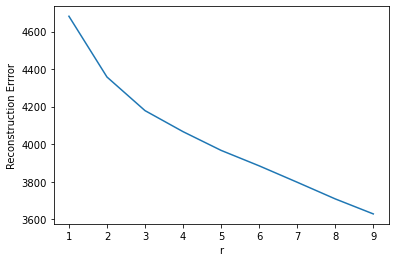

In [22]:
from sklearn.decomposition import NMF

def fit_nmf(r):
    nmf = NMF(n_components=r, init='nndsvd', max_iter=200)
    nmf.fit(M)
    W = nmf.transform(M)
    H = nmf.components_
    return nmf.reconstruction_err_

error = [fit_nmf(i) for i in range(1,10)]
plt.plot(range(1,10), error)
plt.xticks(range(1, 10))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

In [23]:
nmf = NMF(n_components=3)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_

/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [50]:
display(H)

array([[1.04000688e-02, 1.50025091e-02, 1.75854069e-02, 2.17159273e-02,
        1.60248521e-02, 1.60024323e-02, 1.29445837e-02, 1.47094665e-02,
        1.22561308e-02, 1.34997141e-02, 1.70620708e-02, 1.37725334e-02,
        1.56238629e-02, 1.56581175e-02, 1.53399196e-02, 1.71126392e-02,
        1.62640792e-02, 1.06794518e-02, 1.66953239e-02, 1.37937153e-02,
        1.62039215e-02, 1.30884892e-02, 1.67761349e-02, 1.18741431e-02,
        1.56526951e-02, 1.71054731e-02, 1.56467958e-02, 2.49060726e-02,
        2.21082876e-02, 2.62755172e-02, 2.35408741e-02, 2.16188671e-02,
        2.52286687e-02, 1.96014659e-02, 2.79180782e-02, 3.33241861e-02,
        2.30225546e-02, 1.78898604e-02, 2.11690551e-02, 2.01285333e-02,
        2.28671758e-02, 1.83640594e-02, 1.93392957e-02, 1.35039179e-02,
        1.54469866e-02, 1.82525485e-02, 2.16727729e-02, 6.43830537e-02,
        6.22404613e-02, 5.51302666e-02, 3.18983129e-02, 3.30914134e-02,
        3.12775858e-02, 2.90789829e-02, 3.51827409e-02, 1.614748

In [24]:
nmf.reconstruction_err_

4178.635839597622

In [25]:
questions = X.columns.values

In [28]:
hand_labels = []
for i, row in enumerate(H):
    top_five = np.argsort(row)[::-1][:10]
    print('topic', i)
    print('-->', ' '.join(questions[top_five]))
    label = input('please label this topic: ')
    hand_labels.append(label)
    print()

topic 0
--> Q164 Q112 Q159 Q158 Q120 Q48 Q49 Q163 Q106 Q50
please label this topic: morality

topic 1
--> Q186 Q185 Q182 Q172 Q188 Q163 Q158 Q171 Q159 Q184
please label this topic: relationships

topic 2
--> Q178 Q177 Q180 Q181 Q190 Q191 Q194 Q179 Q189 Q192
please label this topic: money

